In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
import yaml
from utils import *
from midi_processing import *
from model import *

# TODO: Implement wandb

2022-04-08 19:47:34.901729: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-08 19:47:35.744034: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-08 19:47:35.744571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-08 19:47:35.770608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 19:47:35.770918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-08 19:47:35.770947: I tensorflow/stream_executor/platfor

In [2]:
config = yaml.safe_load(open('config.yaml', 'r'))

RESOLUTION = 24
MAX_PITCH = 128
MIN_PITCH = 0
INTENSITY = 90
VOCAB_SIZE = 200
PATH_TO_MIDI = os.path.expanduser(os.path.join('~', 'Repositories', 'js-fakes', 'midi', '*.mid'))

In [3]:
midi_path_list = glob(config['path']['data_dir'])

# Get the upper and lower bound of pitches.
# TODO: Split it to each track.
pitch_range = [MAX_PITCH, MIN_PITCH]
for file in midi_path_list:
    midi = pypianoroll.read(file, resolution=config['params']['resolution'])

    for track in midi.tracks:
        new_range = pypianoroll.pitch_range_tuple(track.pianoroll)
        # print(new_range)
        pitch_range = [min(new_range[0], pitch_range[0]), max(new_range[1], pitch_range[1])]
    
print(f"Pitch range = {pitch_range}")

Pitch range = [36, 81]


In [4]:
# Read data from disk.

padding_value = f"0-{config['params']['resolution']}"

encoded_dataset = [[padding_value], [padding_value], [padding_value], [padding_value]] 

for file in midi_path_list:
    
    # TODO: Optimize the structure.
    midi = pypianoroll.read(file, resolution=config['params']['resolution'])
    bin_midi = midi.binarize()
    encoded_tracks = []
    for index, track in enumerate(bin_midi.tracks):
        pr = track.pianoroll.astype('int')
        encoded_pianorolls = []
        for i in range(0, len(pr)//config['params']['resolution']-1):
            encoded_pianorolls.append(beat_encode(pr[config['params']['resolution']*i:config['params']['resolution']*(i+1)]))
        
        # NOTE: Add a padding beat
        encoded_pianorolls.append(padding_value)

        encoded_dataset[index] += encoded_pianorolls
        
        encoded_tracks.append(encoded_pianorolls)

    encoded_tracks = np.array(encoded_tracks)

encoded_dataset = np.array(encoded_dataset)

# print(encoded_dataset.shape)

In [5]:
dev_encoded_string = ",".join(encoded_dataset[0])
dev_encoded_data = [dev_encoded_string]

tokenizer = Tokenizer(num_words=config['params']['vocab_size'], split=',', filters='')
tokenizer.fit_on_texts(dev_encoded_data)
word_index = tokenizer.word_index
train_data = tokenizer.texts_to_sequences(dev_encoded_data)
train_data = to_categorical(train_data)
train_data = np.array(train_data).reshape(train_data.shape[1:])
# print(train_data.shape)


data_size = 20 # Take 10 beats to predict the next (11th) beat.
x_train = []
y_train = []
for i in range(train_data.shape[0]-data_size):
    x_train.append(train_data[i:i+data_size, :])
    y_train.append(train_data[i+data_size, :])

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)


(23601, 20, 200)
(23601, 200)


2022-04-08 19:47:59.949628: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-08 19:47:59.949851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 19:47:59.950329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-08 19:47:59.950409: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-08 19:47:59.950445: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-08 19:47:59.950469: I tensorflow/stream_executor/plat

Epoch 1/50


2022-04-08 19:48:00.713568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-08 19:48:00.730195: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


2022-04-08 19:48:01.701889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-08 19:48:01.857940: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-04-08 19:48:01.877912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


369/369 [==============================] - 4s 5ms/step - loss: 3.6955 - accuracy: 0.1166
Epoch 2/50
369/369 [==============================] - 2s 5ms/step - loss: 2.6604 - accuracy: 0.3119
Epoch 3/50
369/369 [==============================] - 2s 5ms/step - loss: 2.3535 - accuracy: 0.3723
Epoch 4/50
369/369 [==============================] - 2s 5ms/step - loss: 2.2170 - accuracy: 0.3980
Epoch 5/50
369/369 [==============================] - 2s 5ms/step - loss: 2.0961 - accuracy: 0.4254
Epoch 6/50
369/369 [==============================] - 2s 5ms/step - loss: 2.0150 - accuracy: 0.4315
Epoch 7/50
369/369 [==============================] - 2s 5ms/step - loss: 1.9266 - accuracy: 0.4476
Epoch 8/50
369/369 [==============================] - 2s 5ms/step - loss: 1.8476 - accuracy: 0.4593
Epoch 9/50
369/369 [==============================] - 2s 5ms/step - loss: 1.7532 - accuracy: 0.4860
Epoch 10/50
369/369 [==============================] - 2s 5ms/step - loss: 1.6342 - accuracy: 0.5093
Epoch 11/5

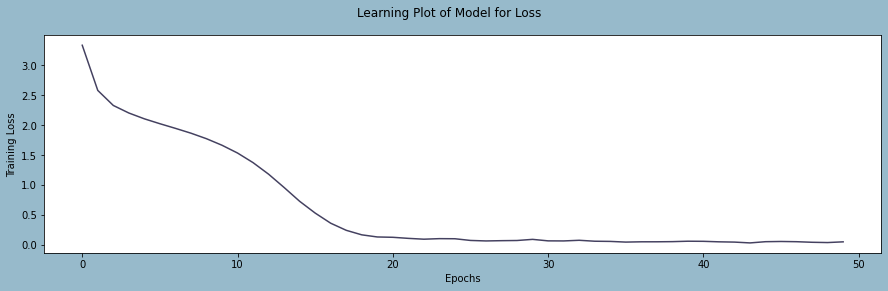

In [6]:
model = LoFiLoopNet()
model.train(x_train, y_train)
model.plot()

In [121]:
# Generate a midi song using trained model.

# TODO: Rewrite it to read params from yaml.
def midi_generator(model, midi_path):

    # Save a midi generated from the model to disk

    bpm = 120
    length = 20 # sec

    beats = bpm//60*length

    pick = random.randint(0, len(midi_path_list))
    midi = pypianoroll.read(midi_path_list[pick], resolution=RESOLUTION)
    # midi = pypianoroll.read('dummy_input.mid', resolution=RESOLUTION)
    
    # TODO: Optimize the structure.
    encoded_dataset = [[], [], [], []]

    bin_midi = midi.binarize()
    encoded_tracks = []
    for index, track in enumerate(bin_midi.tracks):
        pr = track.pianoroll.astype('int')
        encoded_pianorolls = []
        for i in range(0, len(pr)//RESOLUTION-1):
            encoded_pianorolls.append(beat_encode(pr[RESOLUTION*i:RESOLUTION*(i+1)]))
        
        # NOTE: Add a padding beat
        encoded_pianorolls.append(padding_value)

        encoded_dataset[index] += encoded_pianorolls
        
        encoded_tracks.append(encoded_pianorolls)

    encoded_tracks = np.array(encoded_tracks)

    input_seed = encoded_tracks[0, :data_size]
    
    for i in range(len(input_seed)):
        input_seed[i] = word_index[input_seed[i]]
    

    input_seed = to_categorical(input_seed, num_classes=VOCAB_SIZE)
    # input_seed = np.array(input_seed).reshape(1, input_seed.shape[0], input_seed.shape[1])
    midi_sequence = input_seed.copy()
    input_seed = np.expand_dims(input_seed, axis=0)
    print(input_seed.shape)

    
    for _ in range(beats):
        next_beat = model.predict(input_seed, verbose=0)
        next_beat = np.argmax(next_beat) 
        next_beat = to_categorical(next_beat, num_classes=VOCAB_SIZE)
        next_beat = np.array(next_beat).reshape(1, next_beat.shape[0])

        midi_sequence = np.append(midi_sequence, next_beat, axis=0)

        input_seed = np.append(input_seed[0], next_beat, axis=0)
        input_seed = input_seed[1:, :]
        input_seed = np.expand_dims(input_seed, axis=0)

    print(midi_sequence.shape)

    pianoroll_sequence = []
    for index, beat in enumerate(midi_sequence):
        word_val = np.argmax(beat)
        encoded_beat = get_key(word_index, word_val)
        decoded_beat = beat_decode(encoded_beat)

        pianoroll_sequence.append(decoded_beat)
    
    pianoroll_sequence = np.array(pianoroll_sequence)
    pianoroll_sequence = pianoroll_sequence.reshape(pianoroll_sequence.shape[0]*pianoroll_sequence.shape[1], pianoroll_sequence.shape[2])
    pianoroll_sequence = pianoroll_sequence * INTENSITY
    print(pianoroll_sequence.shape)
    
    std_track = pypianoroll.StandardTrack(pianoroll=pianoroll_sequence)
    output = pypianoroll.Multitrack(resolution=RESOLUTION, tracks=[std_track])
    pypianoroll.write(midi_path, output)

    
midi_generator(model, f'experiment_datasize_{data_size}.mid')

(1, 20, 200)
(60, 200)
(1440, 128)
